Here is 👉 the Link [Google-Colab](https://colab.research.google.com/drive/13VTV_EU9u3KEse8qXhgnwsFzNRfv-rqw#scrollTo=M9qdYFZd9Q-J)

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

# Download the Data through Kaggle API
from google.colab import files

In [ ]:
# Using Kaggle API to Download the Dataset

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
# Download the Dataset
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2

100% 2.17G/2.18G [01:46<00:00, 24.8MB/s]
100% 2.18G/2.18G [01:46<00:00, 21.8MB/s]


In [ ]:
# After Downloaded and Unzip the file through this code

In [ ]:
from zipfile import ZipFile
file_name = "/content/comic-faces-paired-synthetic-v2.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')
  zip.extractall(path="/content")

Done


In [ ]:
import glob,random,os,shutil

In [ ]:
comics = glob.glob('/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics/**/*.jpg',recursive=True)
faces = glob.glob('/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/**/*.jpg',recursive=True)

random.shuffle(faces)
random.shuffle(comics)

train_perc = 0.8

os.makedirs('/content/real_comic_data/train/real')
os.makedirs('/content/real_comic_data/train/comic')
os.makedirs('/content/real_comic_data/val/real')
os.makedirs('/content/real_comic_data/val/comic')

for file in faces[:round(len(faces)*train_perc)]:
    shutil.copy(file,'/content/real_comic_data/train/real/')

for file in faces[round(len(faces)*train_perc):]:
    shutil.copy(file,'/content/real_comic_data/val/real/')

for file in comics[:round(len(comics)*train_perc)]:
    shutil.copy(file,'/content/real_comic_data/train/comic/')

for file in comics[round(len(comics)*train_perc):]:
    shutil.copy(file,'/content/real_comic_data/val/comic/')

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [512, 512]

train_path = '/content/real_comic_data/train/'
valid_path = '/content/real_comic_data/val/'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
 # useful for getting number of output classes
folders = glob.glob('/content/real_comic_data/train/*')

In [ ]:
folders

['/content/real_comic_data/train/comic', '/content/real_comic_data/train/real']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='sigmoid')(x)
# prediction.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/real_comic_data/train/',
                                                 target_size = (512, 512),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 16000 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/real_comic_data/val/',
                                            target_size = (512, 512),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 4000 images belonging to 2 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-20-baa5bdd1dea3>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
250/250 [==============================] - 1090s 4s/step - loss: 0.0184 - accuracy: 0.9971 - val_loss: 0.0566 - val_accuracy: 0.9985
Epoch 2/10
250/250 [==============================] - 1081s 4s/step - loss: 0.0124 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
250/250 [==============================] - 1081s 4s/step - loss: 3.1217e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
250/250 [==============================] - 1085s 4s/step - loss: 0.0350 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
250/250 [==============================] - 1064s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
250/250 [==============================] - 1061s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
250/250 [==============================] - 1056s 4s/step - loss: 0.0000e+00 - accuracy: 1.000

In [ ]:
import matplotlib.pyplot as plt

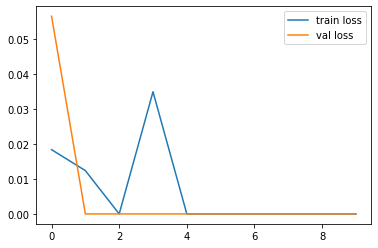

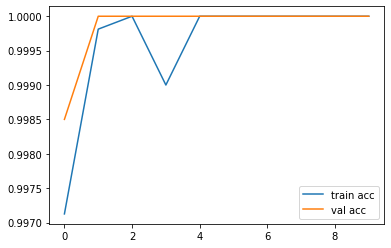

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_inception_2.h5')

In [ ]:
y_pred = model.predict(test_set)

63/63 [==============================] - 78s 1s/step


In [ ]:
y_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_inception_2.h5')


In [ ]:
#Just change the image "path" which is inside 'real' in 'val' in 'real_comic_data' 
real_face=image.load_img('/content/real_comic_data/val/real/1001.jpg',target_size=(512, 512))  



In [ ]:
x=image.img_to_array(real_face)
x

array([[[107., 128., 121.],
        [ 97., 120., 114.],
        [ 96., 121., 117.],
        ...,
        [ 77., 108., 103.],
        [ 85., 116., 111.],
        [ 67.,  98.,  93.]],

       [[ 96., 119., 113.],
        [ 95., 120., 116.],
        [ 88., 114., 111.],
        ...,
        [ 74., 105., 100.],
        [ 87., 118., 113.],
        [ 77., 108., 103.]],

       [[ 98., 123., 119.],
        [ 94., 120., 117.],
        [ 89., 118., 116.],
        ...,
        [ 79., 109., 107.],
        [ 81., 112., 107.],
        [ 71., 102.,  97.]],

       ...,

       [[ 36.,  35.,  30.],
        [ 23.,  22.,  17.],
        [ 41.,  40.,  35.],
        ...,
        [255., 255., 237.],
        [178., 177., 157.],
        [131., 133., 112.]],

       [[ 32.,  31.,  26.],
        [ 34.,  33.,  28.],
        [ 32.,  31.,  26.],
        ...,
        [ 81.,  76.,  57.],
        [105., 104.,  83.],
        [ 95.,  97.,  75.]],

       [[ 16.,  15.,  10.],
        [  8.,   7.,   2.],
        [ 28.,  

In [ ]:
x.shape

(512, 512, 3)

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 512, 512, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 2s 2s/step


array([[1.0000000e+00, 1.6601819e-23]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 27ms/step


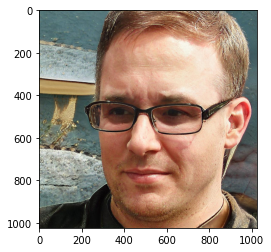

It's a Real Face


In [ ]:
#Just change the image "path" which is inside 'real' in 'val' in 'real_comic_data' 
path = '/content/real_comic_data/val/real/1001.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path)
imgplot = plt.imshow(img)
if (a == 1):
  plt.show()
  print("It's a Comic Face")
else:
  plt.show()
  print("It's a Real Face")

In [ ]:
if (a==1):
  print("It's a Comic Face")
else:
  print("It's a Real Face")

It's a Real Face


In [ ]:
# Now test the Comic Faces

In [ ]:
#Just change the image "path" which is inside 'comic' in 'val' in 'real_comic_data' 
comic_face=image.load_img('/content/real_comic_data/val/comic/100.jpg',target_size=(512, 512))  

In [ ]:
x=image.img_to_array(comic_face)
x

array([[[67., 78., 84.],
        [58., 69., 75.],
        [53., 64., 70.],
        ...,
        [57., 67., 77.],
        [58., 68., 78.],
        [72., 82., 92.]],

       [[58., 69., 75.],
        [59., 70., 76.],
        [56., 67., 73.],
        ...,
        [60., 73., 82.],
        [58., 71., 80.],
        [62., 75., 84.]],

       [[59., 70., 76.],
        [53., 64., 70.],
        [52., 63., 69.],
        ...,
        [57., 70., 79.],
        [56., 69., 78.],
        [56., 69., 78.]],

       ...,

       [[62., 77., 84.],
        [64., 79., 86.],
        [62., 77., 84.],
        ...,
        [ 9.,  9.,  9.],
        [ 4.,  4.,  4.],
        [23., 23., 23.]],

       [[63., 78., 85.],
        [60., 75., 82.],
        [62., 77., 84.],
        ...,
        [ 8.,  8.,  8.],
        [ 2.,  2.,  2.],
        [42., 42., 42.]],

       [[77., 92., 99.],
        [66., 81., 88.],
        [68., 83., 90.],
        ...,
        [22., 22., 22.],
        [24., 24., 24.],
        [83., 83., 83.]]

In [ ]:
x=image.img_to_array(comic_face)
x

array([[[67., 78., 84.],
        [58., 69., 75.],
        [53., 64., 70.],
        ...,
        [57., 67., 77.],
        [58., 68., 78.],
        [72., 82., 92.]],

       [[58., 69., 75.],
        [59., 70., 76.],
        [56., 67., 73.],
        ...,
        [60., 73., 82.],
        [58., 71., 80.],
        [62., 75., 84.]],

       [[59., 70., 76.],
        [53., 64., 70.],
        [52., 63., 69.],
        ...,
        [57., 70., 79.],
        [56., 69., 78.],
        [56., 69., 78.]],

       ...,

       [[62., 77., 84.],
        [64., 79., 86.],
        [62., 77., 84.],
        ...,
        [ 9.,  9.,  9.],
        [ 4.,  4.,  4.],
        [23., 23., 23.]],

       [[63., 78., 85.],
        [60., 75., 82.],
        [62., 77., 84.],
        ...,
        [ 8.,  8.,  8.],
        [ 2.,  2.,  2.],
        [42., 42., 42.]],

       [[77., 92., 99.],
        [66., 81., 88.],
        [68., 83., 90.],
        ...,
        [22., 22., 22.],
        [24., 24., 24.],
        [83., 83., 83.]]

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 512, 512, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 0s 29ms/step


array([[1.0000000e+00, 5.4022242e-20]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 26ms/step


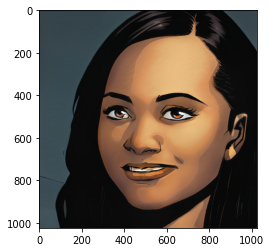

It's a Comic Face


In [ ]:
#Just change the image "path" which is inside 'comic' in 'val' in 'real_comic_data' 

path = '/content/real_comic_data/val/comic/100.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path)
imgplot = plt.imshow(img)
if (a == 1):
  plt.show()
  print("It's a Real Face")
else:
  plt.show()
  print("It's a Comic Face")

In [ ]:
if (a==1):
  print("It's a Real Face")
else:
  print("It's a Comic Face")

It's a Comic Face


This Classification model is working well since we load the image from Real Face data folder this model classified perfecftly